In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

from Generator import Generator
from RealGenerator import RealGenerator
import matplotlib.pyplot as plt

## Parameters

#### Data Generation

In [2]:
low = 1                                    #
high = 10                                 #
rank = False                                  #
normalize = True

train_examples = 10000
test_examples = 100

#### Model

In [3]:
embed_dim = 1024                            #
stack = 6                                    #

optimizer = keras.optimizers.Nadam()         #
loss = keras.losses.MSE                      # Regression Loss Function


metrics = keras.metrics.MeanSquaredError()

2022-04-24 23:27:49.855258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-24 23:27:49.937781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-24 23:27:49.938316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-24 23:27:49.939396: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

#### Training

In [4]:
batch_size = 48
epochs = 1000

validation_split = 0.2
verbose = 2

## Generate Data

In [5]:
generator = Generator('nutrients.csv') # filename with data

In [6]:
generator.generate(train_examples) # generates arg number of examples
generator.scale(low,high) # scales ingredients individually between min and max arg values
if rank:
    generator.rank()
    
if normalize:
    generator.normalize()

In [7]:
generator.recipes.shape

(10000, 15, 13)

## Build Model

In [8]:
embed_dim = embed_dim
stack = stack
i1 = keras.layers.Input(generator.recipes.shape[1:])
f1 = keras.layers.Flatten()(i1)
y1 = keras.layers.Dense(embed_dim)(f1)

# Stack residual blocks (skip connections)
for _ in range(stack):
    y2 = y1
    y1 = keras.layers.Dense(embed_dim,
        activation=keras.activations.relu)(y1)
    y1 = keras.layers.Add()([y1,y2])
    y1 = keras.layers.LayerNormalization()(y1)

if normalize:
    o1 = keras.layers.Dense(generator.recipes.shape[1],activation=keras.activations.softplus)(y1)
    
else:
    o1 = keras.layers.Dense(generator.recipes.shape[1])(y1)
    
model = keras.Model(i1,o1)

In [9]:
#keras.utils.plot_model(model,to_file='recipe_model.png',show_shapes=True,expand_nested=True)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 13)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 195)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         200704      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1024)         1049600     ['dense[0][0]']                  
                                                                                              

In [11]:
model.compile(optimizer=optimizer,
            loss=loss,
            metrics=metrics)

In [12]:
filepath = f"{normalize}_{embed_dim}_{stack}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_freq=250)
callbacks_list = [checkpoint]

## Train

In [13]:
history = model.fit(
    generator.recipes, generator.quant, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split = validation_split, 
    verbose=verbose,
    callbacks = callbacks_list
)

Epoch 1/1000


2022-04-24 23:27:55.614531: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-04-24 23:27:55.784715: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


167/167 - 6s - loss: 0.2284 - mean_squared_error: 0.2284 - val_loss: 0.2224 - val_mean_squared_error: 0.2224 - 6s/epoch - 34ms/step
Epoch 2/1000

Epoch 00002: loss improved from inf to 0.21891, saving model to True_1024_6.h5


/home/chandler/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


167/167 - 3s - loss: 0.2017 - mean_squared_error: 0.2017 - val_loss: 0.1520 - val_mean_squared_error: 0.1520 - 3s/epoch - 16ms/step
Epoch 3/1000

Epoch 00003: loss improved from 0.21891 to 0.12515, saving model to True_1024_6.h5
167/167 - 3s - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 0.1106 - val_mean_squared_error: 0.1106 - 3s/epoch - 16ms/step
Epoch 4/1000
167/167 - 2s - loss: 0.0877 - mean_squared_error: 0.0877 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 2s/epoch - 15ms/step
Epoch 5/1000

Epoch 00005: loss improved from 0.12515 to 0.06438, saving model to True_1024_6.h5
167/167 - 3s - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0620 - val_mean_squared_error: 0.0620 - 3s/epoch - 16ms/step
Epoch 6/1000

Epoch 00006: loss improved from 0.06438 to 0.05913, saving model to True_1024_6.h5
167/167 - 3s - loss: 0.0592 - mean_squared_error: 0.0592 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - 3s/epoch - 16ms/step
Epoch 7/1000
167/167 - 3s - loss: 0.

KeyboardInterrupt: 

NameError: name 'history' is not defined

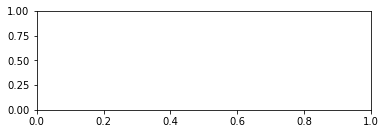

In [14]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['loss'])
plt.ylabel('Progress')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')

## Testing Fake Data

In [15]:
#prediction values
test_gen = Generator('nutrients.csv')
test_gen.generate(test_examples) # generates arg number of examples
test_gen.scale(low,high) # scales ingredients individually between min and max arg values

if rank:
    test_gen.rank()
    
if normalize:
    test_gen.normalize()

In [16]:
test_recipes = test_gen.recipes
test_quant = test_gen.quant

In [17]:
score = model.evaluate(test_recipes, test_quant, verbose=1)

4/4 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_squared_error: 0.0066


In [18]:
pred = model.predict(test_recipes)
if normalize:
    pred = test_gen.inv_normalize(pred)

In [19]:
actual = test_gen.quant
if normalize:
    actual = test_gen.inv_normalize(actual)

In [20]:
index = 3

In [21]:
for i in range(len(pred[0])):
    pred_num = str(round(pred[index,i],3))
    act_num = str(round(actual[index,i],3))
    
    print(f"pred: {pred_num} | actual: {act_num}" )

pred: 0.002 | actual: 0.0
pred: 6.682 | actual: 7.056
pred: 8.161 | actual: 8.595
pred: 0.08 | actual: 0.0
pred: 5.329 | actual: 5.634
pred: 8.311 | actual: 8.505
pred: 2.277 | actual: 2.331
pred: 0.002 | actual: 0.0
pred: 4.06 | actual: 4.185
pred: 5.168 | actual: 5.202
pred: 6.521 | actual: 7.281
pred: 0.004 | actual: 0.0
pred: 0.018 | actual: 0.0
pred: 0.66 | actual: 1.404
pred: 6.072 | actual: 5.949


## Testing Real Data

In [22]:
recipe_quant = "./Recipe Data.csv"
ingr_nutr = "./nutrients.csv"

In [23]:
from RealData import RealData

In [24]:
realdata = RealData(recipe_quant,ingr_nutr)

In [25]:
if normalize:
    realdata.normalize()

In [26]:
pred = model.predict(realdata.recipes)
if normalize:
    pred = realdata.inv_normalize(pred)

In [27]:
actual = realdata.quant
if normalize:
    actual = realdata.inv_normalize(actual)

In [33]:
index = 4
for i in range(len(pred[0])):
    pred_num = str(round(pred[index,i],3))
    act_num = str(round(actual[index,i],3))
    
    print(f"pred: {pred_num} | actual: {act_num}" )

pred: 0.826 | actual: 5.6
pred: 205.861 | actual: 295.0
pred: 0.065 | actual: 5.7
pred: 481.276 | actual: 476.0
pred: 0.438 | actual: 0.0
pred: 45.548 | actual: 25.2
pred: 0.356 | actual: 0.0
pred: 0.374 | actual: 0.0
pred: 0.102 | actual: 0.0
pred: 1.029 | actual: 0.0
pred: 52.9 | actual: 19.5
pred: 0.284 | actual: 0.0
pred: 0.459 | actual: 0.0
pred: 0.821 | actual: 0.0
pred: 0.559 | actual: 0.0
